In [67]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GRU + Meta data DAG model 


**Sequence Data Version:** `v8.2`


**Meta Data Version:**: `v2.1`



In [134]:
import numpy as np
import pandas as pd

import sys
sys.path.append('../')

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile

## Load Datasets

In [135]:
import numpy as np
import pandas as pd

from tqdm import tqdm
from config import interim_data_dir, raw_data_dir

from src.utils import read_shapefile_resampled as read_shapefile

from config import processed_data_dir


# Sequential Data
dataset_version = 'v8.2'

train_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'train.csv', index_col=0)
test_features_df = pd.read_csv(processed_data_dir/'VI_datasets'/dataset_version/'test.csv', index_col=0)

# This is necessary for some reason
train_features_df.farm_id = train_features_df.farm_id.astype(str)
test_features_df.farm_id = test_features_df.farm_id.astype(str)

# Meta data
metadata_version = 'v2.1'
train_meta_df = pd.read_csv(processed_data_dir / 'meta_data' / metadata_version / "train_scaled.csv", index_col=0)
test_meta_df = pd.read_csv(processed_data_dir / 'meta_data' / metadata_version / "test_scaled.csv", index_col=0)

## Process Data

### Sequential Data

In [136]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler


def impute_nan_inf(df):
    """
    Impute bad values (nan and inf) using
    the median of that feature on that time stamp
    for all farms
    
    TODO: This can be improved
    """
    
    # replace all nans variants with np.nan
    df = df.replace([np.nan, None, np.inf, -np.inf], np.nan)

    # replace all nans with the median value of all farms on that timestamp
    for ts, ts_df in df.groupby('time'):
        df.loc[ts_df.index] = ts_df.fillna(ts_df.median())
        
    return df
        
    
train_features_df = impute_nan_inf(train_features_df)
test_features_df = impute_nan_inf(test_features_df)

### 2. Scale Features

In [137]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

scaler = MinMaxScaler()

feature_cols = [col for col in train_features_df.columns if col not in ['farm_id','y','time']]

train_scaled = train_features_df.copy()
test_scaled = test_features_df.copy()

train_scaled.loc[:, feature_cols] = scaler.fit_transform(train_features_df[feature_cols])
test_scaled.loc[:, feature_cols] = scaler.transform(test_features_df[feature_cols])

## Create Train / Val Split with oversampling

1. Create wide-form dataset
2. Split out val set
3. Oversample train set
4. Turn back into long-form

### 1. Create Wide Dataset

In [138]:
from sklearn.model_selection import train_test_split

feature_cols = [c for c in train_features_df.columns.to_list() if c not in ['time','farm_id','y']]

def long_to_wide(df):
    
    df_long = pd.pivot(df, index='farm_id', columns='time')
    
    columns = ['-'.join(col_pair) for col_pair in df_long.columns if 'y' not in col_pair]
    
    if 'y' in df:
        
        classes = {}
        for farm_id, farm_group in df.groupby('farm_id'):
            classes[farm_id] = farm_group.y.unique()[0]
        
        labels = pd.Series(classes, name='y')
        
        df_long.drop('y', axis=1, inplace=True)
        
        df_long = df_long.join(labels, on='farm_id')
        
        columns.append('y')
        
    df_long.columns = columns
    
    return df_long

In [139]:
# Make wide-form training set
train_features_df_wide = long_to_wide(train_scaled)
train_features_df_wide.head()

,reip_min-2017-01-31,reip_min-2017-02-28,reip_min-2017-03-31,reip_min-2017-04-30,reip_min-2017-05-31,reip_min-2017-06-30,reip_min-2017-07-31,reip_min-2017-08-31,reip_max-2017-01-31,reip_max-2017-02-28,...,msbi_median-2017-08-31,msbi_std-2017-01-31,msbi_std-2017-02-28,msbi_std-2017-03-31,msbi_std-2017-04-30,msbi_std-2017-05-31,msbi_std-2017-06-30,msbi_std-2017-07-31,msbi_std-2017-08-31,y
farm_id,,,,,,,,,,,,,,,,,,,,,
1,0.568996,0.764163,0.616210,0.508593,0.400975,0.391401,0.398822,0.392872,0.301011,0.378803,...,0.000000,0.667064,0.790269,0.588857,0.528198,0.467540,0.481260,0.473417,0.506413,Vineyard
1000,0.628780,0.641101,0.531394,0.447725,0.364056,0.340577,0.356648,0.327569,0.280906,0.279423,...,0.446727,0.641601,0.576854,0.534703,0.484717,0.434730,0.453058,0.470476,0.431499,Vineyard
1002,0.628569,0.657572,0.591777,0.532836,0.473895,0.397706,0.398375,0.401395,0.340499,0.327153,...,0.664277,0.588225,0.528465,0.491116,0.511710,0.532303,0.511844,0.509287,0.566372,Vineyard
1003,0.668922,0.720224,0.553341,0.466967,0.380594,0.394159,0.459174,0.501261,0.384975,0.465312,...,0.635944,0.649815,0.661054,0.515315,0.496043,0.476770,0.503435,0.552698,0.609662,Vineyard
1004,0.619985,0.752473,0.657592,0.640565,0.623539,0.637631,0.630049,0.586935,0.255279,0.490972,...,0.000000,0.644070,0.691076,0.604697,0.674534,0.744371,0.742668,0.712134,0.704241,Lucern


## Add meta data
...

In [140]:
train_meta_df.index = train_meta_df.index.astype(str)

train_wide = train_features_df_wide.join(train_meta_df, on='farm_id')
train_wide.head()

,reip_min-2017-01-31,reip_min-2017-02-28,reip_min-2017-03-31,reip_min-2017-04-30,reip_min-2017-05-31,reip_min-2017-06-30,reip_min-2017-07-31,reip_min-2017-08-31,reip_max-2017-01-31,reip_max-2017-02-28,...,Cotton,Dates,Grass,Lucern,Maize,Pecan,Vacant,Vineyard,"Vineyard & Pecan (""Intercrop"")",nn_count
farm_id,,,,,,,,,,,,,,,,,,,,,
1,0.568996,0.764163,0.616210,0.508593,0.400975,0.391401,0.398822,0.392872,0.301011,0.378803,...,0.990434,-0.146653,-0.482659,-0.580470,-0.672012,1.226142,-0.779975,0.106967,0.889687,-1.102456
1000,0.628780,0.641101,0.531394,0.447725,0.364056,0.340577,0.356648,0.327569,0.280906,0.279423,...,-0.412259,-0.146653,-0.482659,0.424872,-0.672012,2.094398,-0.779975,0.106967,-0.405631,0.688066
1002,0.628569,0.657572,0.591777,0.532836,0.473895,0.397706,0.398375,0.401395,0.340499,0.327153,...,-0.412259,-0.146653,-0.482659,1.932885,-0.672012,0.357886,-0.779975,-0.304091,-0.405631,1.225223
1003,0.668922,0.720224,0.553341,0.466967,0.380594,0.394159,0.459174,0.501261,0.384975,0.465312,...,-0.412259,-0.146653,-0.482659,-0.077799,-0.091881,2.094398,-0.779975,0.106967,-0.405631,1.762379
1004,0.619985,0.752473,0.657592,0.640565,0.623539,0.637631,0.630049,0.586935,0.255279,0.490972,...,-0.412259,-0.146653,0.687167,0.927543,-0.091881,0.357886,-0.779975,-0.304091,-0.405631,1.404275


### 2. Split out val set

In [165]:
# Split out val set
X_wide = train_wide.drop('y', axis=1)
y = train_features_df_wide.y

X_train_wide, X_val_wide, y_train, y_val = train_test_split(X_wide, y, stratify=y, test_size=0.2, random_state=2019)

# Save for later
wide_col_names = X_wide.columns
X_wide_train_index = X_train_wide.index

X_train_wide.shape, X_val_wide.shape

((1995, 721), (499, 721))

### 3. Over Sample

1. Random up-sample `Dates` to 10 samples
2. Synthetically up-sample all clases below certain value (tuning)

In [166]:
from imblearn.over_sampling import RandomOverSampler

# Up sample dates
random = RandomOverSampler({'Dates': 10},random_state=2019)
X_train_temp, y_train_temp = random.fit_resample(X_train_wide, y_train)

pd.Series(y_train_temp).value_counts()

Vineyard                          753
Lucern                            429
Maize                             226
Vacant                            213
Pecan                             117
Cotton                            113
Grass                              76
Vineyard & Pecan ("Intercrop")     62
Dates                              10
dtype: int64

In [174]:
from imblearn.over_sampling import ADASYN


# oversample the training set
sample = ADASYN(sampling_strategy={
                'Grass': 150,
                'Vineyard & Pecan ("Intercrop")':  100,
                'Dates': 20,
                'Pecan': 170,
              }, 
              random_state=2019,
              )

X_train_wide_resampled, y_train_resampled = sample.fit_resample(X_train_temp, y_train_temp)

In [175]:
pd.Series(y_train_resampled).value_counts()

Vineyard                          753
Lucern                            429
Maize                             226
Vacant                            213
Pecan                             172
Grass                             151
Vineyard & Pecan ("Intercrop")    114
Cotton                            113
Dates                              20
dtype: int64

**Turn oversampled data into DataFrame with new Farm IDs**

In [176]:
# Turn oversampled training set into long form
X_train_wide = pd.DataFrame(X_train_wide_resampled, columns=wide_col_names)

# Make new index
new_train_index = pd.Index(data=list(X_wide_train_index) + [f'os_{i}' for i in range(X_train_wide.shape[0] - len(X_wide_train_index))])
X_train_wide['farm_id'] = new_train_index
y_train = pd.Series(y_train_resampled, index=new_train_index, name='y')

X_train_wide.tail()

,reip_min-2017-01-31,reip_min-2017-02-28,reip_min-2017-03-31,reip_min-2017-04-30,reip_min-2017-05-31,reip_min-2017-06-30,reip_min-2017-07-31,reip_min-2017-08-31,reip_max-2017-01-31,reip_max-2017-02-28,...,Dates,Grass,Lucern,Maize,Pecan,Vacant,Vineyard,"Vineyard & Pecan (""Intercrop"")",nn_count,farm_id
2186,0.565894,0.582415,0.463939,0.417350,0.370761,0.331598,0.331663,0.336163,0.278120,0.312913,...,-0.146653,-0.482659,-1.029045,0.881082,1.814076,-0.094386,-0.449724,0.889687,-0.284273,os_191
2187,0.597281,0.682349,0.535654,0.422686,0.309719,0.293686,0.317814,0.335322,0.339243,0.448925,...,-0.146653,-0.482659,-0.077799,1.343143,-0.281854,-0.779975,0.215154,-0.405631,-1.224937,os_192
2188,0.600200,0.666263,0.593741,0.470481,0.347222,0.309423,0.336948,0.382887,0.277853,0.354656,...,-0.146653,-0.482659,-1.083141,1.327707,0.357886,-0.567553,0.631681,-0.405631,-1.331015,os_193
2189,0.584943,0.673246,0.461415,0.391075,0.320734,0.306888,0.315412,0.319302,0.279747,0.341367,...,-0.146653,-0.482659,-0.199370,-0.672012,-0.510370,1.524832,-0.105262,1.871731,0.400754,os_194
2190,0.664368,0.722597,0.489998,0.464424,0.438850,0.390677,0.415851,0.407750,0.267652,0.371706,...,-0.146653,-0.482659,-0.985240,-0.446036,1.587085,-0.779975,0.518026,2.185004,1.055547,os_195


### 4. From wide back to long form


In [177]:
train_meta_df.head()

,Area,Subregion_3.0,Subregion_1.0,Subregion_4.0,Subregion_2.0,Subregion_5.0,Subregion_6.0,Subregion_0.0,Subregion_7.0,lat,...,Cotton,Dates,Grass,Lucern,Maize,Pecan,Vacant,Vineyard,"Vineyard & Pecan (""Intercrop"")",nn_count
Field_Id,,,,,,,,,,,,,,,,,,,,,
1,-0.589766,1,0,0,0,0,0,0,0,1.739183,...,0.990434,-0.146653,-0.482659,-0.58047,-0.672012,1.226142,-0.779975,0.106967,0.889687,-1.102456
2,-0.157671,1,0,0,0,0,0,0,0,1.761063,...,-0.412259,-0.146653,-0.482659,-0.58047,-0.672012,0.357886,-0.779975,1.340142,0.889687,-0.207195
3,-0.527917,1,0,0,0,0,0,0,0,1.753355,...,0.990434,-0.146653,-0.482659,-0.58047,-0.672012,1.226142,-0.779975,0.106967,0.889687,-0.744352
4,-0.439169,1,0,0,0,0,0,0,0,1.764898,...,0.289088,-0.146653,-0.482659,-0.58047,-0.672012,1.226142,-0.779975,0.518026,0.889687,-0.744352
7,1.145875,1,0,0,0,0,0,0,0,1.765042,...,-0.412259,-0.146653,-0.482659,-0.58047,-0.672012,1.226142,-0.779975,0.929084,0.889687,-0.386247


In [178]:
# Remove the meta data again
meta_features = train_meta_df.columns
X_train_meta = X_train_wide[meta_features]
X_val_meta = X_val_wide[meta_features]

X_train = X_train_wide.drop(meta_features, axis=1)
X_train = pd.wide_to_long(X_train, feature_cols, i='farm_id', j='time', sep='-',suffix='\d+-\d+-\d+').sort_index(level=0)

X_val = X_val_wide.drop(meta_features, axis=1)
# Validation set wasn't touched, to just use data from after splitting
X_val = pd.wide_to_long(X_val.reset_index(), feature_cols, i='farm_id', j='time', sep='-',suffix='\d+-\d+-\d+').sort_index(level=0)

# Join the labels back on
train_features = X_train.join(y_train, on='farm_id')
val_features = X_val.join(y_val, on='farm_id')

In [179]:
train_features = X_train.join(y_train, on='farm_id')
val_features = X_val.join(y_val, on='farm_id')

## Transform Dataset for Modelling

Data needs to be in the format: `(n_samples, n_time_steps, n_features)`

In [180]:
n_time_steps = 8

def transform_dataset(features_df):
    """
    Create a data array in the shape (n_ids, n_time, n_features)
    
    If it is the training set, also return dictionary mapping index
    in dataset to correct label.
    
    """
    
    n_ids = features_df.farm_id.nunique()

    feature_cols = [col for col in features_df.columns if col not in ['farm_id','y','time']]
    
    n_features = len(feature_cols)

    data = np.ndarray((n_ids, n_time_steps, n_features))
    
    classes = {} # {index: label}
    for i, (farm_id, farm_df) in enumerate(features_df.groupby(['farm_id'])):

        data[i,:,:] = farm_df[feature_cols].values
        
        if 'y' in features_df.columns:
            c = farm_df['y'].unique()
            classes[i] = c[0]
            
    return data, classes

In [181]:
train_data, train_labels = transform_dataset(train_features.reset_index())
train_data_meta = X_train_meta.values

val_data, val_labels = transform_dataset(val_features.reset_index())
val_data_meta = X_val_meta.values

test_data, _ = transform_dataset(test_features_df)
test_data_meta = test_meta_df.values

print('Train data:{}\t\tMeta: {}'.format(train_data.shape, train_data_meta.shape))
print('Val Data: {}\t\tMeta: {}'.format(val_data.shape , val_data_meta.shape))
print('Test data:{}\t\tMeta: {}'.format(test_data.shape, test_data_meta.shape))

Train data:(2191, 8, 85)		Meta: (2191, 41)
Val Data: (499, 8, 85)		Meta: (499, 41)
Test data:(1074, 8, 85)		Meta: (1074, 41)


## Encode labels to 0-9

In [182]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_labels_enc = le.fit_transform(np.array(list(train_labels.values())).reshape(-1,1))
val_labels_enc = le.transform(np.array(list(val_labels.values())).reshape(-1,1))

In [183]:
class_weights = (1 - pd.Series(train_labels_enc).value_counts(normalize=True)).to_dict()

class_weights

{7: 0.6563213144682793,
 3: 0.8041989958922866,
 4: 0.896850753080785,
 6: 0.9027841168416249,
 5: 0.9214970333181196,
 2: 0.9310816978548608,
 8: 0.9479689639434048,
 0: 0.9484253765403925,
 1: 0.9908717480602465}

## Start Modelling Process

### Create validation set

### Create model

In [187]:
import tensorflow as tf
import keras
from keras import models, layers
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from src.visualization.tf_viz import PlotLosses

from keras.layers import Input, Dense
from keras.models import Model

n_time_steps = 8

def get_dag_model(n_ts_features, n_meta_features):
    
    # Get the model
    GRU_cells = 8
    recurrent_activation = 'hard_sigmoid'
    recurrent_dropout = 0.4
    
    dense_dropout=0.2


    # Temporal Model
    input_timeseries = Input(shape=(n_time_steps, n_ts_features,))

    x = layers.Dense(8, activation='relu')(input_timeseries)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dense_dropout)(x)
    x = layers.Dense(16, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dense_dropout)(x)
    x = layers.GRU(GRU_cells, 
                         return_sequences=True,
                         recurrent_activation=recurrent_activation, 
                         recurrent_dropout=recurrent_dropout)(x)
    x = layers.GRU(GRU_cells, 
                         return_sequences=True,
                         recurrent_activation=recurrent_activation, 
                         recurrent_dropout=recurrent_dropout)(x)
#     x = layers.GRU(GRU_cells, 
#                          return_sequences=True,
#                          recurrent_activation=recurrent_activation, 
#                          recurrent_dropout=recurrent_dropout)(x)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dense_dropout)(x)

    
    # Meta Model
    input_meta_data = Input(shape=(n_meta_features,))

    y = layers.Dense(64, activation='relu',)(input_meta_data)
    y = layers.BatchNormalization()(y)
    y = layers.Dropout(dense_dropout)(y)
#     y = layers.Dense(16, activation='relu')(y)
#     y = layers.Dropout(dense_dropout)(y)
#     y = layers.BatchNormalization()(y)

    bottleneck = layers.concatenate([x,y])
    bottleneck = layers.Dense(16, activation='relu')(bottleneck)
    bottleneck = layers.Dropout(dense_dropout)(bottleneck)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.Dense(9, activation='softmax')(bottleneck)

    model = Model(inputs=[input_timeseries,input_meta_data], outputs=bottleneck)
    
    return model

### Set modelling parameters

In [188]:
from src.models.clr_callback import CyclicLR
from keras.callbacks import ModelCheckpoint

from config import models_dir

plot_losses = PlotLosses()
es = EarlyStopping(monitor='val_loss', verbose=1, patience=100)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=30, verbose=1, factor=0.5, min_delta=0.001,)

f_checkpoint_val = str(models_dir / f'gru_dag_val_{dataset_version}.{metadata_version}.hdf5')
checkpoint = ModelCheckpoint(f_checkpoint_val, 
                             save_best_only=True, 
                             mode='min', 
                             monitor='val_loss')


# Combine Callbacks
callbacks = [
    plot_losses, 
    es, 
    reduce_lr,
    checkpoint
]

# Create model & compile
model = get_dag_model(train_data.shape[-1], train_data_meta.shape[-1])

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 8, 85)        0                                            
__________________________________________________________________________________________________
dense_66 (Dense)                (None, 8, 8)         688         input_21[0][0]                   
__________________________________________________________________________________________________
batch_normalization_66 (BatchNo (None, 8, 8)         32          dense_66[0][0]                   
__________________________________________________________________________________________________
dropout_66 (Dropout)            (None, 8, 8)         0           batch_normalization_66[0][0]     
__________________________________________________________________________________________________
dense_67 (

In [ ]:
# lr = 0.00015
lr=3e-4

# Choose optimizer
# optimizer = keras.optimizers.RMSprop(lr)
optimizer = keras.optimizers.Adam(lr)


model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy')

## TRAIN!!

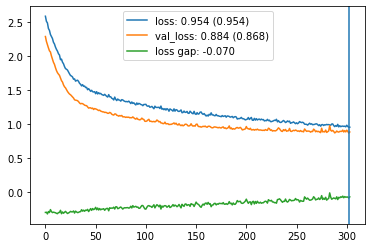

In [ ]:
batch_size = 64
epoch_size = 1000

model.fit([train_data, train_data_meta], 
          train_labels_enc,
          batch_size=batch_size,
          validation_data=([val_data, val_data_meta], val_labels_enc), 
          verbose=0,
          epochs=epoch_size, 
          callbacks=callbacks)

### Inspect best model performance

In [ ]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
from src.visualization.visualize import print_confusion_matrix

# Load best model
best_model = load_model(str(models_dir / f'gru_dag_val_{dataset_version}.{metadata_version}.hdf5'))

class_labels = pd.read_csv(raw_data_dir / 'crop_id_list.csv', index_col=0).sort_index().crop

val_probs = best_model.predict([val_data, val_data_meta])

val_preds = np.argmax(val_probs, axis=1)

cm = confusion_matrix(val_labels_enc, val_preds)
print_confusion_matrix(cm, class_names=class_labels);

In [ ]:
from sklearn.metrics import classification_report

pd.DataFrame(classification_report(val_labels_enc, val_preds, output_dict=True))

In [ ]:
pd.DataFrame(classification_report(val_labels_enc, val_preds, output_dict=True))

### Now on all data

In [ ]:
all_data = np.vstack([train_data, val_data])
all_labels = np.array(list(train_labels_enc) + list(val_labels_enc))

all_data_meta = np.vstack([train_data_meta, val_data_meta])

class_weight = (1 - pd.Series(all_labels).value_counts(normalize=True)).to_dict()

In [ ]:
from src.models.clr_callback import CyclicLR
from keras.callbacks import ModelCheckpoint

from config import models_dir

from keras.layers import Input, Dense
from keras.models import Model

lr = 0.00015

# Choose optimizer
optimizer = keras.optimizers.RMSprop(lr)
f_checkpoint = str(models_dir / f'gru_dag_{dataset_version}.{metadata_version}.hdf5')
checkpoint = ModelCheckpoint(f_checkpoint, 
                             save_best_only=True, 
                             mode='min', 
                             monitor='loss')
callbacks = [
    plot_losses, 
    checkpoint
]

model = get_dag_model(all_data.shape[-1], all_data_meta.shape[-1])

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy')

model.summary()

In [ ]:
epochs=150

model.fit([all_data,all_data_meta], 
          all_labels,
          batch_size=batch_size,
          class_weight=class_weight,
          verbose=0,
          epochs=epochs, 
          callbacks=callbacks)

### Load Best Model

In [ ]:
from keras.models import load_model

model = load_model(f_checkpoint)

In [ ]:
f_checkpoint

## Make a submission

In [ ]:
def make_sub(predictions, ids_list):
    
    sub_df = pd.read_csv(raw_data_dir / 'sample_submission_fixed.csv')

    new_sub = sub_df.copy().set_index('field_id')

    new_sub.loc[ids_list] = predictions
    
    return new_sub

predictions = model.predict([test_data, test_meta_data])
test_ids = sorted(list(test_features_df.farm_id.unique()))
sub_df = make_sub(predictions, test_ids)
sub_df.head()

### Save submission file

In [ ]:
from config import subs_dir

fname = 'gru_dag_data_v7.2'
sub_df.to_csv(subs_dir / f'{fname}.csv')

### Save model architecture

In [ ]:
with open(subs_dir / 'architectures' / f'{fname}.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))